In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

['China' 'France' 'Italy' 'Korea, South' 'Spain' 'US']
DatetimeIndex(['2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
               '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
               '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
               '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07'],
              dtype='datetime64[ns]', freq=None)


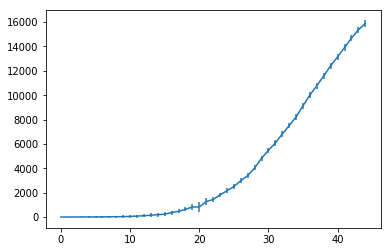

In [3]:
import pandas as pd
from datetime import datetime,timedelta
giturl_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

corona_cases_df=pd.read_csv(giturl_deaths, index_col=[0,1,2,3])  
#   use first four columns as multiindex




country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

wanted_countries = ['China', 'Korea','Italy', 'France', 'US', 'Spain']

countries_list = [np.unique(np.array([s for s in country_official_list if cou in s])) 
                                                 for cou in wanted_countries]
countries_list = np.array(countries_list).flatten()
countries_list.sort()
print(countries_list)


cases_percountry = {}
df_dict = {}
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') 
                   for da in cases_percountry[country].index]
    
    df_dict[country] = pd.DataFrame(cases_percountry[country], 
                                    columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1, 
                                             cases_percountry[country].shape[0]+1)
    
    
country = 'Korea, South'
country = 'Spain'
country = 'Italy'

print(df_dict[country].index)
#print(df_dict['Italy']['Cases'])  #print cases every three days

# for country in countries_list:
#     print(country)
#     dates=df_dict[country].index
#     plt.semilogy(dates, np.array(list(df_dict[country]['Cases'].values)), label=country)
#     plt.legend(loc='lower right')
#     plt.tick_params(rotation=45, labelsize=12)
#     #plt.ylabel(casestr, fontsize=14)
# plt.xlim([dates[0]-np.timedelta64(3,'D'), dates[-1]+np.timedelta64(10,'D')])
# plt.show()

if country == 'Italy':
    nPop = 60260000
    icuBeds = 7500
if country == 'Spain':
    nPop = 46722000
    icuBeds = 3500
if country == 'France':
    nPop = 67000000
    icuBeds = 7000
    
nPredictDays = 10
maxdelay = 40

#testdays = np.arange(60)

#starting at 21 feb 

#print(np.array(list(df_dict[country]['Cases'].values)))
deaths_data = np.array(list(df_dict[country]['Cases'].values))


deaths_data = deaths_data[:-2]





#np.array([1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825,5476,6077,6820,7503,8215,9134,10023,10779,11591,12428,13155,13915, 14681, 15362 ])
#nPop/(1+np.exp(-(testdays-20)*0.2))*0.0015

deaths_past = np.zeros(maxdelay + deaths_data.size)
deaths_past[maxdelay:] = deaths_data
#keep the relative error low at 1%. if all measurements were independent it would be low.
#but errors even out in time mostly - here we assume a tiny fraction of cases does not 
#besides the constant 

#shot noise: every delta has sigma = sqrt(delta). day i var is cumsum of sigma^2=delta, so the original total. 
#additionally, we assume per day 10 deaths may go unnoticed early in the first two weeks - systematic error... 
#we could also assume a percentage of delta per day is a random added error, but these are not independent and even out late
#while not important initally. 
shotnoise = np.sqrt(deaths_data)
unnoticed = 10*np.ones(deaths_data.shape)
unnoticed[14:] = 0
deaths_error = np.cumsum(unnoticed) + shotnoise

if country == 'Italy':
    deaths_error[19] += 100
    deaths_error[20] += 250
    deaths_error[21] += 100
    
    
time_past = np.arange(deaths_past.size)-maxdelay
time_data = np.arange(deaths_data.size)
time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay


#plt.plot(time_past, deaths_past)
plt.errorbar(time_data, deaths_data, deaths_error)



deathdata = np.zeros((2, deaths_data.size))
deathdata[0, :] = deaths_data
deathdata[1, :] = deaths_error

if country == 'Italy':
    discontdays = np.array([1, 9, 12, 29]) #removed 32 
    discontvals = np.array([1,0.6,0.5,0.4])
if country == 'Spain':
    discontdays = np.array([8, 10, 25]) #removed 32 
    discontvals = np.array([1,0.6,0.2])
if country == 'France':
    discontdays = np.array([22, 28, 30, 31]) #removed 32 
    discontvals = np.array([1,0.8,0.2, 0.1])

discontdata = np.zeros((3, discontdays.size))
discontdata[0, :] = discontdays
discontdata[1, :] = discontvals
discontdata[2, :] = discontvals # > 0 means sample this (else fixed)
#discontdata[2, 1] = -1         # < 0 means fix 

data = mcmc.DiseaseData(deathdata,  discontdata)

In [13]:
def loglike(icuBeds, probSerious, probAsymp, hospitalSlope, probLethalIfSerious): 
    
    print('starting optim with probSerious = {}, probAsymp = {}, hospital slope = {}, probLethalIfSerious = {}'.format(probSerious, probAsymp, hospitalSlope, probLethalIfSerious))
    params = mcmc.DiseaseParams()
    params.probLethalDailyWhenSeriousUntreated = 0.4
    params.probSerious = probSerious #unknown, higher for older population - should be possible to extract from Diamond Princess. 
    #I think about 30 were serious... 30/700 would then be upper limit, so at most 5% for old people. 
    #Conistency check: 6(factor below)*11(dead on diamond princess) = 66... okay, more than 30. So 10% serious for old people.
    # this number is between 0.02 and 0.1. need to line search max likelihood

    params.probLethal = params.probSerious*probLethalIfSerious #out of 50~49 serious cases, 7 dead in Aachen study https://www.aerzteblatt.de/archiv/213454
    params.probAsymp = probAsymp
    params.timeIncub = 6  #chinese like studies...
    params.timeIncubSigma = 4

    #obained to match median 4, IQR 7 from Aachen study https://www.aerzteblatt.de/archiv/213454
    params.timeMildToSerious = 7.1 
    params.timeMildToSeriousSigma = 13

    #Drosten study https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1 
    #: 9 patients, all virus present after 5 days of symptoms. Let's say then that chance shorter ~ 10%. 
    # seroconversion early week 2 progressive decrease in viral load in samples. 10 days most gone. 
    #let's take lognormal with 5 at 10% CDF and 10 at 90% CDF 
    params.timeMildDuration = 7.4 
    params.timeMildDurationSigma = 2

    # Aachen Median acht Tage (IQR 5–11) for all, including most that did not die. 
    # This is longer with larger spread than the recovered group. We choose Median 8.6, IQR 6.6 to get 
    params.timeSeriousToDeath = 10
    params.timeSeriousToDeathSigma = 6

    # less important: 
    # Aachen Median 7 Tage [IQR 6–11])
    params.timeSeriousToRecovered = 8
    params.timeSeriousToRecoveredSigma = 4.5


    data.initialBetaMild = 2
    data.initialBetaHigh = 10
    data.initialDelay = 23
    data.computeR = False
    #data.computeOnlyLikelihood = False
    data.fixBehaviorInAdvance = 10
    
    
    covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, hospitalSlope, maxdelay, nPredictDays)


    state = mcmc.State()
    state.add(covid)
    smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
    state.add(smooth)

    #print(state.getAll())
    state.sharedDependencyMaxDepth = 5
    
    for i in range(4):
        target = mcmc.CoolingTarget(9)
        target.set_posterior(state)
        chain = mcmc.Chain(target, 0)
        chain.computeMean = False
        chain.recordSamples = True
        chain.run(0,0,100,1)
        print(chain.getLoglikes()[-1])



   
    return chain.getLoglikes()[-1], chain



In [14]:

n1 = 6
n2 = 5
n3 = 4
n4 = 5

g1 = np.linspace(0.02, 0.045, n1)
g2 = np.linspace(0.15, 0.45, n2)
g3 = np.linspace(10, 40, n3)
g4 = np.linspace(0.13, 0.17, n4)



l, chain = loglike(icuBeds, g1[5], g2[3], g3[0], g4[0] )



starting optim with probSerious = 0.045, probAsymp = 0.375, hospital slope = 10.0, probLethalIfSerious = 0.13
-4.620758148498372
-4.080025863997632
-3.465658628729897
-2.903224432297621


[29.43545082]
[9.41602904]
[2.22916747]
[0.78082669 0.78082669 0.78082669 0.0011522 ]
[1.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.30635245e-07  2.43370900e-06  1.36092301e-05  4.49236399e-05
  1.11522069e-04  2.29198737e-04  4.27804251e-04  7.72196788e-04
  1.36241168e-03  2.36535043e-03  4.07330974e-03  6.97434886e-03
  1.18940315e-02  2.02450373e-02  3.44082452e-02  5.84151363e-02
  9.91179971e-02  1.68129219e-01  2.85129621e-01  4.83495040e-01
  8.19811651e-01  1.38998635e+00  2.35662039e+00  3.99536881e+00
  6.77349857e+00  1.14829527e+01  1.94656576e+01  3.29947124e+01
  5.59181733e+01  9.47435167e+01  1.60456203e+02  2.71546048e+02
  1.25380427e+03  4.32856646e+03  1.03959817e+04  2.07021483e+04
  3.70129266e+04  6.15799898e+04  9.68689000e+04  1.45079796e+05

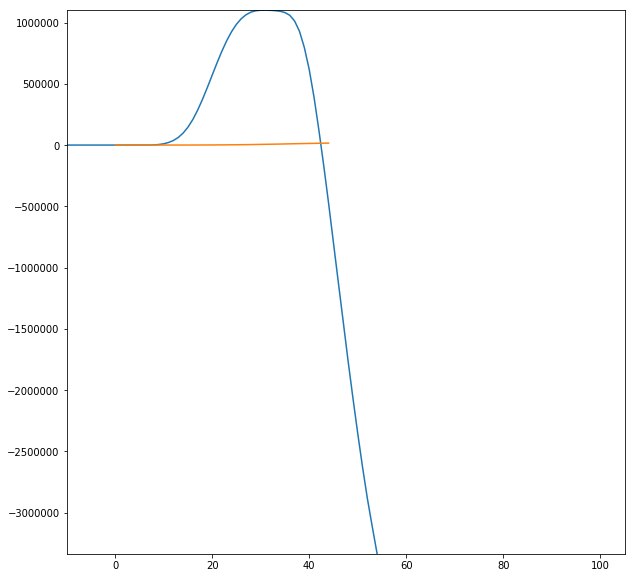

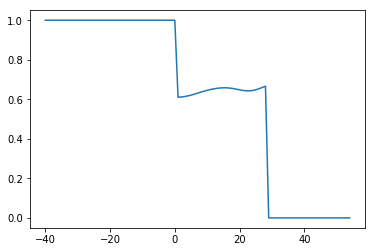

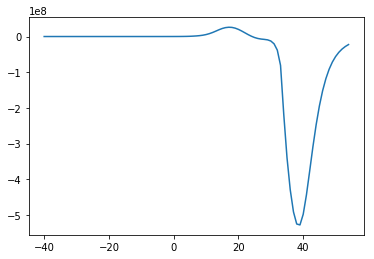

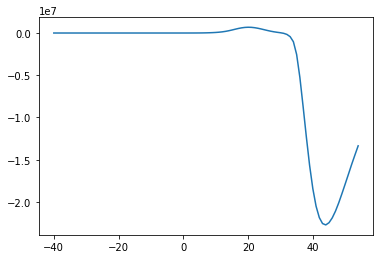

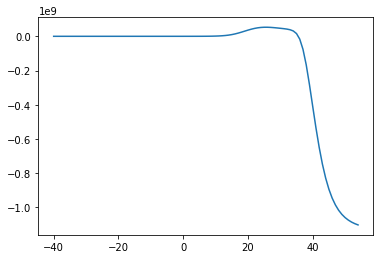

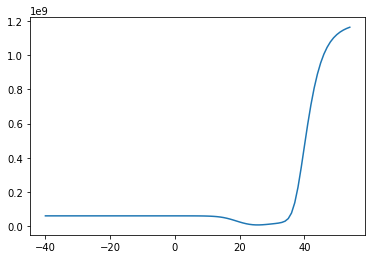

[0.]


ValueError: x and y must have same first dimension, but have shapes (95,) and (1,)

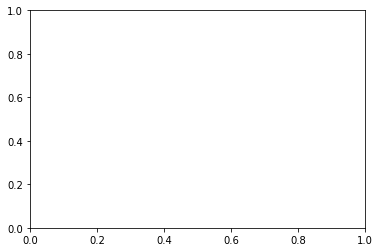

In [10]:
#plt.plot(time_all, chain.getMean("dead")[:] - np.mean(chain.getSamples("dead"),0))
#plt.show()

print(chain.getSamples("delay")[-1])
print(chain.getSamples("betaHigh")[-1])
print(chain.getSamples("betaMild")[-1])
print(chain.getSamples("discontinuousVals")[-1])

print(chain.getSamples("missedDeaths")[-1])


plt.figure(figsize=(10,10))
plt.plot(time_all, chain.getSamples("dead")[-1,:])
print(chain.getSamples("dead")[-1,:])
#for i in range(110): 
#    plt.plot(time_all, chain.getSamples("dead")[-1-35*i,:])


plt.errorbar(time_data, deaths_data, deaths_error)
plt.xlim([-10, deaths_data.size+60])

lims = plt.gca().get_xlim()
i = np.where( (time_all > lims[0]) &  (time_all < lims[1]) )[0]
plt.gca().set_ylim( chain.getMean("dead")[i].min(), chain.getMean("dead")[i].max() )

plt.show()


plt.plot(time_all, chain.getSamples("totalBehavior")[-1,:])
plt.show()

plt.plot(time_all, chain.getSamples("mild")[-1,:])
plt.show()
 
plt.plot(time_all, chain.getSamples("serious")[-1,:])
plt.show()
 

plt.plot(time_all, chain.getSamples("recovered")[-1,:])
plt.show()

plt.plot(time_all, nPop-chain.getSamples("recovered")[-1,:])
plt.show()

print(chain.getSamples("R")[-1,:])
plt.plot(time_all, chain.getSamples("R")[-1,:])
plt.show()

In [ ]:
n1 = 6
n2 = 5
n3 = 4
n4 = 5

# (array([1, 1, 2, 3, 4]), array([3, 3, 3, 1, 1]), array([0, 1, 0, 1, 1]), array([0, 0, 0, 0, 0]))
#winner is first, 1 3 0 0. Second is fourth, 3 1 1 0. 
#
# for i1, probSerious in enumerate(np.linspace(0.02, 0.06, n1)):
#     for i2, probAsymp in enumerate(np.linspace(0.1, 0.4, n2)):
#         for i3, hosp in enumerate(np.linspace(10, 100, n3)): 
#             for i4, probLethalIfSerious in enumerate(np.linspace(0.14, 0.1922, n4)):

# 1 loop: (array([2, 3, 3, 5]), array([4, 2, 2, 3]), array([1, 1, 3, 1]), array([4, 2, 3, 1]))
# winner is last, 5 3 1 1, second is third, 3 2 3 3 
# 4 loops: 
#(array([5, 5, 5, 5]), array([2, 3, 3, 3]), array([2, 0, 1, 2]), array([0, 0, 1, 1]))
# 5 3 0 0 best, 5 3 1 1 and 5 2 2 0 second 
#(array([1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5]), array([2, 4, 3, 3, 3, 4, 4, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3]), array([0, 1, 0, 0, 1, 0, 1, 3, 0, 1, 2, 0, 0, 0, 2, 3, 0, 1, 2]), array([3, 2, 2, 4, 3, 4, 4, 3, 1, 2, 0, 0, 1, 3, 0, 1, 0, 1, 1]))
#
# for i1, probSerious in enumerate(np.linspace(0.02, 0.045, n1)):
#     for i2, probAsymp in enumerate(np.linspace(0.15, 0.45, n2)):
#         for i3, hosp in enumerate(np.linspace(10, 40, n3)): 
#             for i4, probLethalIfSerious in enumerate(np.linspace(0.13, 0.17, n4)):
res = np.zeros((n1,n2,n3,n4))

g1 = np.linspace(0.02, 0.045, n1)
g2 = np.linspace(0.15, 0.45, n2)
g3 = np.linspace(10, 40, n3)
g4 = np.linspace(0.13, 0.17, n4)

for i1, probSerious in enumerate(np.linspace(0.02, 0.045, n1)):
    for i2, probAsymp in enumerate(np.linspace(0.15, 0.45, n2)):
        for i3, hosp in enumerate(np.linspace(10, 40, n3)): 
            for i4, probLethalIfSerious in enumerate(np.linspace(0.13, 0.17, n4)):
                
                l, chain = loglike(probSerious, probAsymp, hosp, probLethalIfSerious)
                res[i1,i2,i3,i4] = l
                
                
                

(array([5, 5, 5]), array([2, 3, 3]), array([2, 0, 1]), array([0, 0, 1]))
-1.3911191126645892


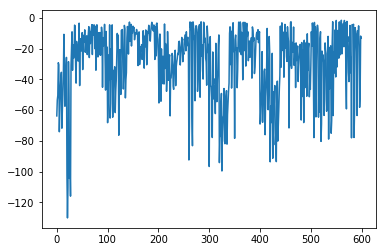

In [37]:
print(np.where(res > 1.2*np.max(res)))
print(np.max(res))
plt.plot(res.flatten())


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.44229176e-12 3.00023557e-07
 5.20009284e-06 2.45113659e-05 7.13740344e-05 1.63387810e-04
 3.13279564e-04 5.70833936e-04 1.01524752e-03 1.76365140e-03
 3.02939987e-03 5.17280073e-03 8.78075499e-03 1.48614794e-02
 2.51180122e-02 4.23815756e-02 7.14566758e-02 1.20424624e-01
 2.02894292e-01 3.41771044e-01 5.75671708e-01 9.69579144e-01
 1.63292711e+00 2.75001941e+00 4.63120552e+00 7.79906202e+00
 1.31136854e+01 2.17415748e+01 3.50051766e+01 5.42895530e+01
 8.09565605e+01 1.17246972e+02 1.65799237e+02 2.30181384e+02
 3.15890626e+02 4.28874699e+02 5.73542190e+02 7.52647752e+02
 9.65596570e+02 1.21109135e+03 1.48527173e+03 1.78283424e+03
 2.10209479e+03 2.441146

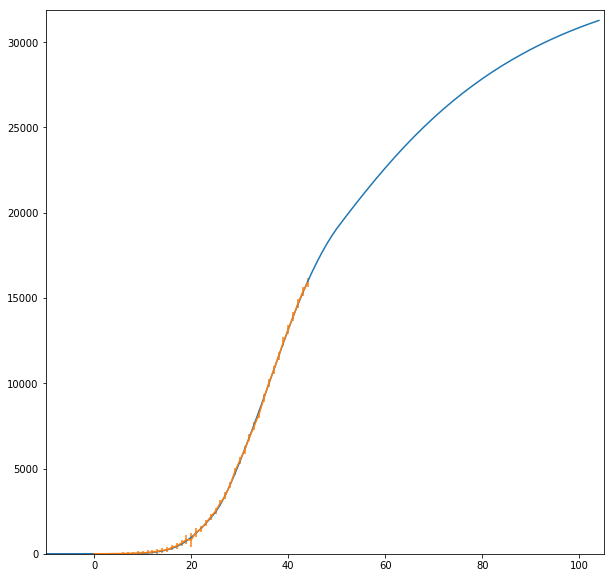

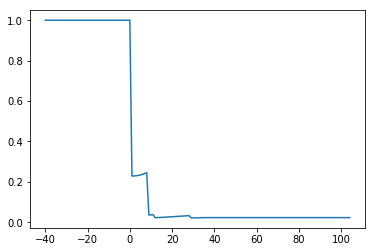

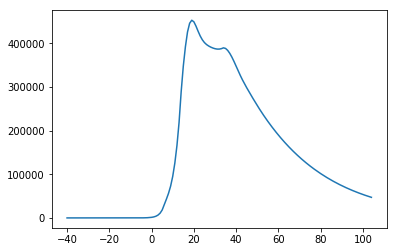

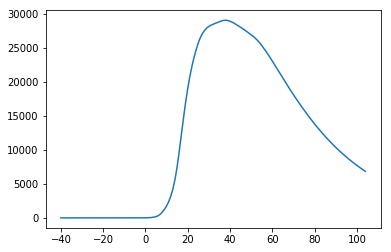

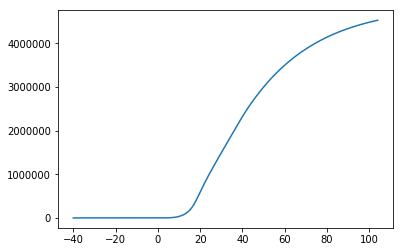

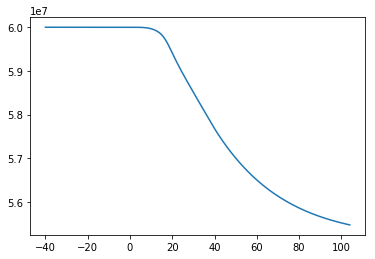

In [39]:
#plt.plot(time_all, chain.getMean("dead")[:] - np.mean(chain.getSamples("dead"),0))
#plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_all, chain.getSamples("dead")[-1,:])
print(chain.getSamples("dead")[-1,:])
#for i in range(110): 
#    plt.plot(time_all, chain.getSamples("dead")[-1-35*i,:])


plt.errorbar(time_data, deaths_data, deaths_error)
plt.xlim([-10, deaths_data.size+60])

lims = plt.gca().get_xlim()
i = np.where( (time_all > lims[0]) &  (time_all < lims[1]) )[0]
plt.gca().set_ylim( chain.getMean("dead")[i].min(), chain.getMean("dead")[i].max() )

plt.show()


plt.plot(time_all, chain.getSamples("totalBehavior")[-1,:])
plt.show()

plt.plot(time_all, chain.getSamples("mild")[-1,:])
plt.show()
 
plt.plot(time_all, chain.getSamples("serious")[-1,:])
plt.show()
 

plt.plot(time_all, chain.getSamples("recovered")[-1,:])
plt.show()

plt.plot(time_all, nPop-chain.getSamples("recovered")[-1,:])
plt.show()